<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_992952/3071175742.py:87: SyntaxWarning: invalid escape sequence '\m'
  axur.set_ylabel("Magnetic Moment ($\mu_N$)")
2026-01-06 18:36:40 [INFO] - Starting Function hyperfine_ham...
2026-01-06 18:36:40 [INFO] - Function hyperfine_ham took 0.1569 seconds
2026-01-06 18:36:40 [INFO] - Starting Function zeeman_ham...
2026-01-06 18:36:40 [INFO] - Function zeeman_ham took 0.0049 seconds
2026-01-06 18:36:40 [INFO] - Starting Function solve_system...
2026-01-06 18:36:40 [INFO] - Starting Function eigh...
2026-01-06 18:36:42 [INFO] - Function eigh took 1.6108 seconds
2026-01-06 18:36:42 [INFO] - Starting Function sort_smooth...
2026-01-06 18:36:42 [INFO] - Function sort_smooth took 0.1931 seconds
2026-01-06 18:36:42 [INFO] - Function solve_system took 1.8082 seconds
2026-01-06 18:36:42 [INFO] - Starting Function label_states...
2026-01-06 18:36:42 [INFO] - Function label_states too

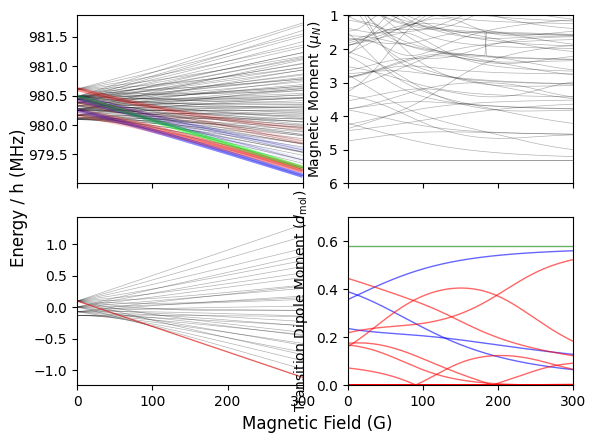

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

import diatomic
from diatomic.systems import SingletSigmaMolecule
import diatomic.operators as operators
import diatomic.calculate as calculate
from diatomic.plotting import colorline

GAUSS = 1e-4  # T
MHz = scipy.constants.h * 1e6
muN = scipy.constants.physical_constants["nuclear magneton"][0]

# Set logging
diatomic.configure_logging()

# Generate Molecule
mol = SingletSigmaMolecule.from_preset("Rb87Cs133")
mol.Nmax = 1

# Generate Hamiltonians
H0 = operators.hyperfine_ham(mol)
Hz = operators.zeeman_ham(mol)

# Parameter Space
B_MIN_GAUSS = 0.001
B_MAX_GAUSS = 300
B = np.linspace(B_MIN_GAUSS, B_MAX_GAUSS, 300) * GAUSS

# Overall Hamiltonian
Htot = H0 + Hz * B[:, None, None]

# Solve (diagonalise) Hamiltonians
eigenenergies, eigenstates = calculate.solve_system(Htot)

# Apply labels (in some way arbitrary) warn if duplicate
eigenlabels = calculate.label_states(mol, eigenstates[-1], ["N", "MF"])

magnetic_moments = calculate.magnetic_moment(mol, eigenstates)

groundstate = 0
transition_sigma_plus = calculate.transition_electric_moments(
    mol, eigenstates[:, :, :], h=1, from_states=groundstate
)
transition_pi = calculate.transition_electric_moments(
    mol, eigenstates[:, :, :], h=0, from_states=groundstate
)
transition_sigma_minus = calculate.transition_electric_moments(
    mol, eigenstates[:, :, :], h=-1, from_states=groundstate
)

# Plot results

fig, ((axul, axur), (axdl, axdr)) = plt.subplots(2, 2, sharex=True)

base = (2 * mol.Ii[0] + 1) * (2 * mol.Ii[1] + 1)

axdl.plot(B / GAUSS, eigenenergies[:, 0:base] / MHz, c="k", lw=0.5, alpha=0.3)
axul.plot(B / GAUSS, eigenenergies[:, base : 4 * base] / MHz, c="k", lw=0.5, alpha=0.3)

axur.plot(B / GAUSS, magnetic_moments[:, 0 : 4 * base] / muN, c="k", lw=0.5, alpha=0.3)


cs = ["green", "blue", "red"]
rgbis = [1, 2, 0]
h = [transition_sigma_plus, transition_pi, transition_sigma_minus]

for c, rgbi, transition_elements in zip(cs, rgbis, h):
    axdr.plot(
        B / GAUSS,
        transition_elements[:, groundstate, :] / mol.d0,
        c=c,
        lw=1,
        alpha=0.6,
    )

    for eigindex in range(32, 128):
        colours = np.zeros((B.shape[0], 4))
        colours[:, rgbi] = 1
        colours[:, 3] = transition_elements[:, groundstate, eigindex] / mol.d0
        colorline(axul, B / GAUSS, eigenenergies[:, eigindex] / MHz, colors=colours)

axdl.plot(B / GAUSS, eigenenergies[:, groundstate] / MHz, c="red", lw=1, alpha=0.5)

axur.set_ylim(6, 1)
axur.set_ylabel("Magnetic Moment ($\mu_N$)")
axdr.set_ylabel(r"Transition Dipole Moment ($d_{\mathrm{mol}}$)")

axdl.set_xlim(0, B_MAX_GAUSS)

axdr.set_ylim(0, 0.7)

fig.supxlabel("Magnetic Field (G)")
fig.supylabel("Energy / h (MHz)")

plt.show()
